In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np

from astropy import constants as c

Grav = c.G.si.value
M_sun = c.M_sun.si.value

import diskwarp
from diskwarp import helper

#%matplotlib widget
#%config InlineBackend.figure_format = 'retina'

# Add local eddy version to path
import sys

path = '/home/moon/azuleta/gitcommon/eddy/'
sys.path.append(path)
from eddy import rotationmap

## Set the system geometrical properties

In [2]:
d = 140. # pc

PA = 0.
inc = 45.

tilt  = 45.
twist = 30.
w_r0  = 0.4 # 0.4 # 
w_dr  = 0.2 # being r0/4 doesnt affect


## Make the eddy velocity map

Create a cube object

In [3]:
path = './disk_incl10.0phi0.0_inc30.0PA45.0_r040dr10_M1.fits'
uncertainty = './disk_incl10.0phi0.0_inc30.0PA45.0_r040dr10_dM1.fits'

cube = rotationmap(path=path,
                   uncertainty=uncertainty, FOV=1.0)
# Not important
#cube.plot_data()

In [4]:
# Dictionary to contain the disk parameters.
params = {}

# Start with the free variables in p0.
params['x0'] = 0.0
params['y0'] = 0.0
params['vlsr'] = 0.
params['dist'] = d # parsec
params['PA'] = PA + 90
params['inc'] = inc
params['mstar'] = 2.4

# Warp parameters
params['w_i'] = 0#20.
params['w_t'] = 1#35.
params['w_r0'] = 2#0.242
params['w_dr'] = 3#0.18

p0 = [30., 45., 0.20, 0.20]

# Surface parameters
params['z0'] = 0.0#.1

In [5]:
x0   = 0.0
y0   = 0.0
w_i = tilt
w_t = twist
w_r0 = w_r0 # 0.4 # 
w_dr = w_dr # being r0/4 doesnt affect

Text(0.5, 1.0, 'PA = 90.0, inc = 45.0, twist = 30.0, tilt = 45.0')

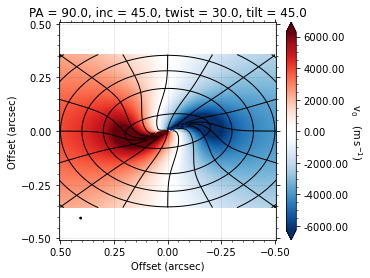

In [6]:
samples = np.array([[w_i, w_t, w_dr, w_r0]])

model = cube.evaluate_models(samples=samples, params=params)

# Get the surface
contour_kwargs = dict(levels=np.arange(0.1, 0.7, 0.1))
fig_model = cube.plot_model_surface(samples,
                                    params,
                                    return_fig=True,
                                    contour_kwargs=contour_kwargs)
ax_model = fig_model.get_axes()[0]

# Overplot the surface
cube.plot_model(model=model, ax=ax_model, return_fig=False)


ax_model.set_title(f'PA = {PA + 90}, inc = {inc}, twist = {twist}, tilt = {tilt}')

#

#fig_model.savefig(f'eddy_PA{PA}inc{inc}T{twist}t{tilt}.pdf', dpi=500, bbox_inches='tight')

## Make the velocity map with Til's method

In [7]:
### General definitions of disk parameters

In [8]:
n_phi = 64
r_i = np.linspace(0.5, 100, 201) # Use up to 100 to compare with radmc3d
r_c = 0.5 * (r_i[1:] + r_i[:-1])

surf     = helper.get_surface(r_i=r_i, nphi=n_phi)
p0_i     = surf['points_i']
p0_c     = surf['points_c']
ri       = surf['ri']
rc       = surf['rc']
phic     = surf['phic']
phii     = surf['phii']
nr, nphi = p0_c.shape[:-1]

In [9]:
r0 = 10/0.4
dr = r0/(10*2)
tilt = tilt
twist = twist

warp_c = helper.warp(r_c, i_in=tilt, r0=r0, dr=dr)
warp_i = helper.warp(r_i, i_in=tilt, r0=r0, dr=dr)

twist_i = helper.twist(r_i, phi=twist, r0=r0, dr=dr) # + np.deg2rad(200.0)
twist_c = helper.twist(r_c, phi=twist, r0=r0, dr=dr) # + np.deg2rad(200.0)

Calculate the velocities of all centers and edges

In [10]:
M_star = 2.4 * M_sun

v0_c = (p0_c[:, :, 0]**2 + p0_c[:, :, 1]**2)**-0.25
v0_c = v0_c * np.sqrt(Grav * M_star/ c.au.cgs.to('m').value) # AU TO CGS
v0_c = v0_c[None, :, :] * np.array([-np.sin(phic), np.cos(phic), np.zeros_like(phic)])
v0_c = np.moveaxis(v0_c, 0, 2)

v0_i = (p0_i[:, :, 0]**2 + p0_i[:, :, 1]**2)**-0.25
v0_i = v0_i * np.sqrt(Grav * M_star/ c.au.cgs.to('m').value)
v0_i = v0_i[None, :, :] * np.array([-np.sin(phii), np.cos(phii), np.zeros_like(phii)])
v0_i = np.moveaxis(v0_i, 0, 2)

Define the inclination of the observer

In [54]:
inc_obs = np.deg2rad(inc)
PA_obs  = np.deg2rad(PA)
azi     = np.deg2rad(0)

## Apply the warp/twist

In [55]:
p1_i = diskwarp.fmodule.apply_matrix2d(p0_i, warp_i, twist_i, inc_obs, PA_obs, azi)
v1_i = diskwarp.fmodule.apply_matrix2d(v0_i, warp_i, twist_i, inc_obs, PA_obs, azi)

## Interpolate on sky plane

In [56]:
_gx = np.linspace(-r_i[-1], r_i[-1], 200)
_gy = np.linspace(-r_i[-1], r_i[-1], 210)
img_xi, img_yi = np.meshgrid(_gx, _gy, indexing='ij')
img_xc = 0.5 * (img_xi[1:, 1:] + img_xi[:-1, 1:])
img_yc = 0.5 * (img_yi[1:, 1:] + img_yi[1:, :-1])

In [57]:
X, Y, Z = p1_i.T
vxi, vyi, vzi = v1_i.T

img_z, img_v = diskwarp.fmodule.interpolate_grid(X, Y, Z, vzi, img_xc, img_yc)
_,     img_r = diskwarp.fmodule.interpolate_grid(X, Y, Z, ri.T, img_xc, img_yc)

In [64]:

img_v[img_v==img_v[0,0]] = np.nan
img_r[img_r==img_r[0,0]] = np.nan

(199, 209)


Make the axes entent match with eddy

In [66]:
RRR = 100 # AU

# Get the arcsec extention

p = RRR/d # arcsec
pp = p * np.cos(inc_obs)
print(p, pp)

__gx = np.linspace(-pp, pp, img_xi.shape[0]-1)
__gy = np.linspace(-p, p, img_xi.shape[1]-1)

img_xi_, img_yi_ = np.meshgrid(__gx, __gy, indexing='ij')


tvals = np.arctan2(img_yi_, img_xi_)

0.7142857142857143 0.5050762722761054


Text(0, 0.5, 'Offsec (arcsec)')

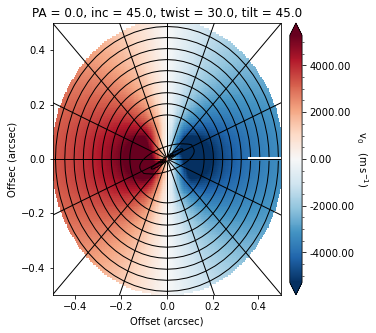

In [62]:
figV, axV = plt.subplots(figsize=(5,5))

vmin, vmax = np.nanpercentile(img_v, [2, 98])
surf = axV.pcolormesh(img_xi_, img_yi_, img_v, cmap='RdBu_r', vmin=vmin, vmax=vmax)
cb = figV.colorbar(surf, ax=axV, extend='both', pad=0.03, format='%.2f')
cb.set_label(label=r'${\rm v_{0} \quad (m\,s^{-1})}$', rotation=270, labelpad=15)
cb.minorticks_on()

# Plot the contour

axV.contour(img_xi_, img_yi_, img_r, 12, colors='k', linewidths=1.0)
for t in np.arange(-np.pi, np.pi, np.pi / 8.0):
            if t - 0.1 < -np.pi:
                a = np.where(abs(tvals - t) <= 0.4,
                             tvals - t, np.nan)
                b = np.where(abs(tvals - 2.0 * np.pi - t) <= 0.4,
                             tvals - 2.0 * np.pi - t, np.nan)
                amask = np.where(np.isfinite(a), 1, -1)
                bmask = np.where(np.isfinite(b), 1, -1)
                a = np.where(np.isfinite(a), a, 0.0)
                b = np.where(np.isfinite(b), b, 0.0)
                ttmp = np.where(amask * bmask < 1, a + b, np.nan)
            elif t + 0.1 > np.pi:
                a = np.where(abs(tvals - t) <= 0.4,
                             tvals - t, np.nan)
                b = np.where(abs(tvals + 2.0 * np.pi - t) <= 0.4,
                             tvals + 2.0 * np.pi - t, np.nan)
                amask = np.where(np.isfinite(a), 1, -1)
                bmask = np.where(np.isfinite(b), 1, -1)
                a = np.where(np.isfinite(a), a, 0.0)
                b = np.where(np.isfinite(b), b, 0.0)
                ttmp = np.where(amask * bmask < 1, a + b, np.nan)
            else:
                ttmp = np.where(abs(tvals - t) <= 0.4, tvals - t, np.nan)
            axV.contour(img_xi_, img_yi_, ttmp, 0, colors='k', linewidths=1.0)
# Set plot parameters

axV.set_title(f'PA = {PA}, inc = {inc}, twist = {twist}, tilt = {tilt}')

axV.set_xlim(-0.5, 0.5)
axV.set_ylim(-0.5, 0.5)
axV.set_xlabel('Offset (arcsec)')
axV.set_ylabel('Offsec (arcsec)')

#figV.savefig(f'til_PA{PA}inc{inc}T{twist}t{tilt}.pdf', dpi=500, bbox_inches='tight')